In [1]:
import numpy as np
from sklearn.cluster import SpectralClustering,KMeans
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import matthews_corrcoef,accuracy_score,precision_score,recall_score,confusion_matrix
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import os

In [2]:
outputfolder="figures/"

# HL: evaluate this sample
datatype="HEK293T_WT_directRNA" 
# HL: use this model
modelname="hg38retrain_HEK293T_KO1_chrsplitHEK293T_WT_directRNA_epochs1_100_epochs2_88" 
os.makedirs(outputfolder+"/"+modelname+"/",exist_ok = True)

In [3]:
# HL: transfer from dataden "/umms-kinfai/duolin/ying/reditools2_candidates/"
hash_candidat={}
hash_candidat['AFG-H1_directRNA']='H1-AFG.candidate_sites.tab'
hash_candidat['AFG-H9_directRNA']='H9-AFG.candidate_sites.tab'
hash_candidat["PGC-H1_directRNA"]='H1-PGC.candidate_sites.tab'
hash_candidat["DE-H1_directRNA"]='H1-DE.candidate_sites.tab'
hash_candidat["DE-H9_directRNA"]='H9-DE.candidate_sites.tab'
hash_candidat["GM12878_directRNA"]='GM12878.candidate_sites.tab'
hash_candidat["H1-hESC_directRNA"]='H1-hESC.candidate_sites.tab'
hash_candidat["H9-hESC_directRNA"]='H9-hESC.candidate_sites.tab'
hash_candidat['HEK293T_DKO_directRNA']='HEK293T_WT.candidate_sites.tab'
hash_candidat["HEK293T_WT_directRNA"]='HEK293T_WT.candidate_sites.tab'
hash_candidat["HEK_WT_pass"]='HEK293T_WT.candidate_sites.tab'
candidatefile="/nfs/turbo/umms-kinfai/haorli/20240314_ReDD_result_data/figure2a/reditools2_candidates/"+hash_candidat[datatype]


In [4]:
AG_ratio_per_site={}
shortreadcoverage={}
input = open(candidatefile,'r')
for line in input:
    chr_ = line.split()[0]
    pos_ = line.split()[1]
    chrpos=chr_+"-"+pos_
    AG_ratio_per_site[chrpos]=float(line.split("\t")[3])
    shortreadcoverage[chrpos]=float(line.split("\t")[4])

In [5]:
long_reads_min_coverage = longread_coverage_cutoff = 5

In [6]:
#REDD
featuredim=5
windowsize=9
inputfolder="/nfs/turbo/umms-kinfai/haorli/20240314_ReDD_result_data/figure2a/REDD/"
modelname = 'hg38retrain_HEK293T_KO1_chrsplitHEK293T_WT_directRNA_epochs1_100_epochs2_88'
filename=inputfolder+"/"+modelname+"/test_"+datatype+"_onlycandidate.txt"


input = open(filename)
pos_coverage={}
coverage = {}
cutoff = 0.5#0.5
for line in input:
    score=float(line.split("\t")[-1])
    if score>=cutoff:
       predict_label=1
    else:
       predict_label=0
    
    transid= line.split("\t")[2]
    transpos = line.split("\t")[3]
    chrpos = transid+"-"+transpos
    
    if chrpos not in pos_coverage.keys():
        pos_coverage[chrpos]=predict_label
        coverage[chrpos]=1
    else:
        pos_coverage[chrpos]+=predict_label
        coverage[chrpos]+=1

REDD_predict_value_all={}
for site in AG_ratio_per_site:   
     if site in pos_coverage:
          if coverage[site] >= long_reads_min_coverage:
              REDD_predict_value_all[site]=float(pos_coverage[site]/coverage[site])

In [7]:
#Dinopore
inputfolderdinopore="/nfs/turbo/umms-kinfai/haorli/20240314_ReDD_result_data/figure2a/Dinopore/"

filenames=["Testinputschr3chr11.output_prediction_CNN_class0.txt","Testinputschr3chr11.output_prediction_CNN_class1.txt","Testinputschr3chr11.output_prediction_CNN_class2.txt"]

Dinopore_predict_value_all={}
for file in filenames:
    input=open(inputfolderdinopore+"/"+file)
    for line in input:
        if "contig" not in line:
            chr_=line.split()[0]
            pos_=line.split()[1]
            poskey=chr_+"-"+pos_
                
            if len(line.split())==11:
                 Dinopore_predict_value_all[poskey]=float(line.split()[10])
            else:
                 Dinopore_predict_value_all[poskey]=0

In [8]:
inputfolderdeepedit = "/nfs/turbo/umms-kinfai/haorli/20240314_ReDD_result_data/figure2a/DeepEdit/Editing_ratio_genome.txt"

DeepEdit_predict_value_all={}
for file in filenames:
    input=open(inputfolderdeepedit)
    for line in input:
            poskey=line.split()[0]
            DeepEdit_predict_value_all[poskey]=float(line.split()[2])/float(line.split()[1])

In [9]:
from scipy.stats import pearsonr
#only use commonsite
commonsite={} #1029
REDD_true_list=[]
REDD_predict_list = []
DeepEdit_true_list=[]
DeepEdit_predict_list=[]
Dinopore_true_list=[]
Dinopore_predict_list=[]
coords_list = []
# Dinopore_predict_value_all = REDD_predict_value_all
# DeepEdit_predict_value_all = REDD_predict_value_all
for key in Dinopore_predict_value_all:#1259
  if key in REDD_predict_value_all: #1242
      if key in DeepEdit_predict_value_all: #1058
          commonsite[key]=1
          REDD_true_list.append(AG_ratio_per_site[key])
          #REDD_predict_list.append(REDD_predict_value_all[key])
          REDD_predict_list.append(REDD_predict_value_all[key])
          
          Dinopore_true_list.append(AG_ratio_per_site[key])
          Dinopore_predict_list.append(Dinopore_predict_value_all[key])
          
          DeepEdit_true_list.append(AG_ratio_per_site[key])
          DeepEdit_predict_list.append(DeepEdit_predict_value_all[key])
          coords_list.append(key)

REDD_predict_list=np.asarray(REDD_predict_list)
#FPR=len(np.where(predict_ratio_list>0.2)[0])/len(predict_ratio_list)
#print(FPR)
REDD_true_list=np.asarray(REDD_true_list)
#len(predict_ratio_list) 
DeepEdit_predict_list=np.asarray(DeepEdit_predict_list)
Dinopore_predict_list=np.asarray(Dinopore_predict_list)
Dinopore_true_list=np.asarray(Dinopore_true_list)
DeepEdit_true_list=np.asarray(DeepEdit_true_list)

In [10]:
import pandas as pd

In [28]:
# export to csv
df = pd.DataFrame([coords_list,REDD_true_list,REDD_predict_list,Dinopore_predict_list,DeepEdit_predict_list]).T
df.columns = ['Site','truth','ReDD','Dinopore','DeepEdit']
df.to_csv('plot_data/site_ratio.tsv',sep='\t',index=False)

In [29]:
df

,Site,truth,ReDD,Dinopore,DeepEdit
0,chr11-108365794,0.18,0.0,0.0,0.0
1,chr11-108365869,0.12,0.115385,0.0,0.0
2,chr11-108365978,0.08,0.04,0.0,0.12
3,chr11-108367226,0.21,0.015152,0.0,0.293103
4,chr11-111728747,0.17,0.0,0.0,0.088235
...,...,...,...,...,...
2297,chr3-9945897,0.17,0.0,0.0,0.083333
2298,chr3-9945900,0.08,0.0,0.0,0.333333
2299,chr3-9945920,0.1,0.043478,0.0,0.0
2300,chr3-9946031,0.07,0.333333,0.0,0.210526


In [30]:
df['ReDD_error'] = np.abs(df['ReDD']-df['truth'])
df['Dinopore_error'] = np.abs(df['Dinopore']-df['truth'])
df['DeepEdit_error'] = np.abs(df['DeepEdit']-df['truth'])

In [31]:
import scipy.stats

<Axes: >

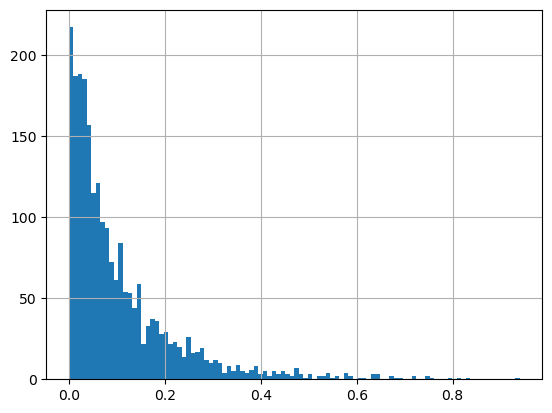

In [32]:
df['ReDD_error'].hist(bins=100)

<Axes: >

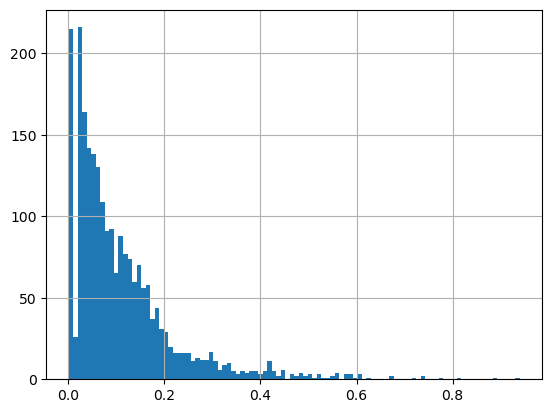

In [33]:
df['Dinopore_error'].hist(bins=100)

In [34]:
scipy.stats.wilcoxon(df['ReDD_error'],df['Dinopore_error'],alternative='less')

WilcoxonResult(statistic=787555.5, pvalue=1.3191977859715372e-07)

In [35]:
scipy.stats.mannwhitneyu(df['ReDD_error'].values.astype(float),df['Dinopore_error'].values.astype(float),alternative='less')

MannwhitneyuResult(statistic=2448163.0, pvalue=3.950522419226768e-06)

In [36]:
scipy.stats.wilcoxon(df['ReDD_error'],df['DeepEdit_error'],alternative='less')

WilcoxonResult(statistic=739245.5, pvalue=1.6192930865632275e-37)

In [37]:
scipy.stats.mannwhitneyu(df['ReDD_error'].values.astype(float),df['DeepEdit_error'].values.astype(float),alternative='less')

MannwhitneyuResult(statistic=2181617.0, pvalue=1.561078852799656e-25)

In [38]:
high_edit_df = df[df['truth'] > 0.8]

In [39]:
high_edit_df['ReDD_error'] = high_edit_df['ReDD']-high_edit_df['truth']
high_edit_df['Dinopore_error'] = high_edit_df['Dinopore']-high_edit_df['truth']
high_edit_df['DeepEdit_error'] = high_edit_df['DeepEdit']-high_edit_df['truth']

/tmp/ipykernel_1634613/4087292381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_edit_df['ReDD_error'] = high_edit_df['ReDD']-high_edit_df['truth']
/tmp/ipykernel_1634613/4087292381.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_edit_df['Dinopore_error'] = high_edit_df['Dinopore']-high_edit_df['truth']
/tmp/ipykernel_1634613/4087292381.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


In [42]:
high_edit_df['ReDD_error'].median()

-0.2965217391304348

In [43]:
high_edit_df['Dinopore_error'].median()

-0.46761624763890497

In [40]:
scipy.stats.wilcoxon(high_edit_df['ReDD_error'],high_edit_df['Dinopore_error'],alternative='greater')

/nfs/turbo/umms-kinfai/haorli/envs/ReDD_plot/lib/python3.11/site-packages/scipy/stats/_morestats.py:3337: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


WilcoxonResult(statistic=286.0, pvalue=0.13557759885441611)

In [45]:
scipy.stats.wilcoxon(high_edit_df['ReDD_error'],high_edit_df['DeepEdit_error'],alternative='greater')

/nfs/turbo/umms-kinfai/haorli/envs/ReDD_plot/lib/python3.11/site-packages/scipy/stats/_morestats.py:3337: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


WilcoxonResult(statistic=356.0, pvalue=0.005539614549909053)

In [13]:
num_bins = 5
binsize=1/num_bins
def binize_list(true_list,predict_list):
    ratio_list = np.arange(0,1,binsize) #np.random.uniform(0.0, 1.0, 30)
    ratio_list.sort()
    sample_size=[]
    AG_ratios_bin=[]
    predict_ratio_bin = []
    ratio_bin_list=[]
    for index in range(len(ratio_list)):
        start = ratio_list[index]
        end = start+binsize
        index_start_end = np.where((true_list<=end) &(true_list>start))[0]
        if(len(index_start_end)>1):
            ratio_bin_list.append(start)
            AG_ratios_bin.append(true_list[index_start_end])
            predict_ratio_bin.append(predict_list[index_start_end])
            sample_size.append(len(predict_list[index_start_end]))
    return AG_ratios_bin,predict_ratio_bin,sample_size


In [14]:
AG_ratios_bin,predict_ratio_bin,sample_size = binize_list(REDD_true_list,REDD_predict_list)
Dinopore_AG_ratios_bin,Dinopore_predict_ratio_bin,sample_size = binize_list(Dinopore_true_list,Dinopore_predict_list)
DeepEdit_AG_ratios_bin,DeepEdit_predict_ratio_bin,sample_size = binize_list(DeepEdit_true_list,DeepEdit_predict_list)

In [14]:
def cal_MAE(AG_ratios_bin,predict_ratio_bin):
    mae=np.abs(np.asarray([np.median(x) for x in AG_ratios_bin])-np.asarray([np.median(x) for x in predict_ratio_bin])).mean()
    return mae

In [16]:
mae = cal_MAE(AG_ratios_bin,predict_ratio_bin)
Dinopore_mae = cal_MAE(Dinopore_AG_ratios_bin,Dinopore_predict_ratio_bin)
DeepEdit_mae = cal_MAE(DeepEdit_AG_ratios_bin,DeepEdit_predict_ratio_bin)

In [17]:
# export to csv
df = pd.DataFrame([mae,Dinopore_mae,DeepEdit_mae]).T
df.columns = ['ReDD','Dinopore','DeepEdit']
df.to_csv('plot_data/MAE.tsv',sep='\t',index=False)

In [18]:
df

,ReDD,Dinopore,DeepEdit
0,0.161233,0.216326,0.301602


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

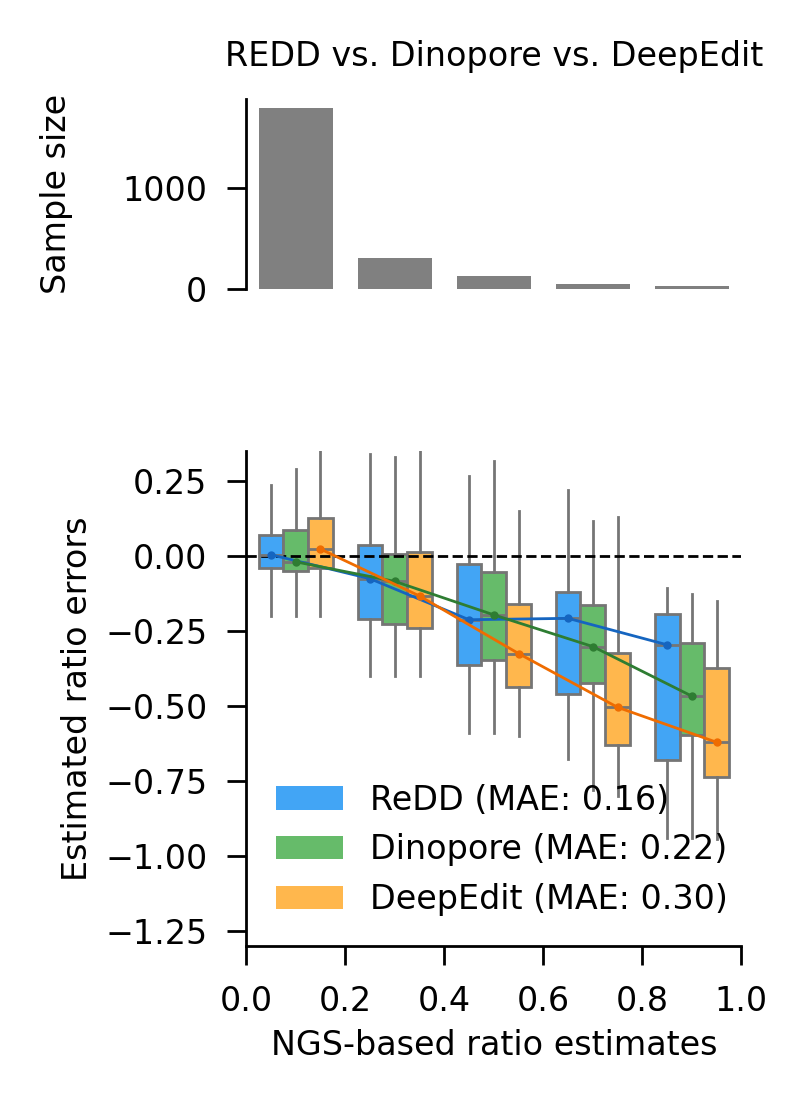

In [19]:
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib as mpl

plt.style.use('ggplot')
plt.style.use('~/tidyplot.mplstyle')
mpl.rcParams['axes.grid'] = False
# mpl.rcParams['lines.linewidth'] = 0.4672897
# mpl.rcParams['grid.linestyle'] = 'solid'
# mpl.rcParams['grid.linewidth'] = 0.4672897

mpl.rcParams['boxplot.showfliers'] = False
mpl.rcParams['boxplot.patchartist'] = True
mpl.rcParams['boxplot.medianprops.color'] = "#757575"
mpl.rcParams['boxplot.medianprops.linewidth'] = 0.5

mpl.rcParams['boxplot.boxprops.color'] = "#757575"
# mpl.rcParams['boxplot.boxprops.facecolor'] = "#90caf9"
mpl.rcParams['boxplot.boxprops.linewidth'] = 0.5

mpl.rcParams['boxplot.whiskerprops.color'] = "#757575"
mpl.rcParams['boxplot.whiskerprops.linewidth'] = 0.5

mpl.rcParams['boxplot.showcaps'] = False
mpl.rcParams['figure.figsize'] = 2,3
#colors=['#90caf9','#e57373','#fff176','#81c784']
colors=['#42a5f5','#66bb6a','#ffb74d','#81c784']
second_colors =['#1565c0','#2e7d32','#ef6c00','#81c784']

num_methods=4
offset = binsize/num_methods/2+binsize/num_methods/2
f, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [0.5, 2]}, sharex=True)
ax2.set_box_aspect(1)
ax1.set_title('REDD vs. Dinopore vs. DeepEdit')
#ax1.bar([binsize*i+offset for i in range(num_bins)], [x for x in sample_size],   yerr=0, width=binsize/num_methods*3,align='center', ecolor='black', capsize=10,label="sample size",color="grey")
ax1.bar([binsize*i++binsize/num_methods+offset for i in range(num_bins)], [x for x in sample_size],   yerr=0, width=binsize/num_methods*3,align='center', ecolor='black', capsize=10,label="sample size",color="grey")
#ax1.bar([binsize*i++binsize/num_methods*2+offset for i in range(num_bins)], [x for x in sample_size],   yerr=0, width=binsize/num_methods,align='center', ecolor='black', capsize=10,label="sample size",color="grey")



ax1.set_ylabel('Sample size\n')
ax1.get_xaxis().set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.set_xlim(0, 1)
ReDD_errors=[[x1-x2 for x1,x2 in zip(sublist1,sublist2)] for sublist1,sublist2 in zip(predict_ratio_bin,AG_ratios_bin)]
ax2.get_xticks()

ax2.boxplot(x=ReDD_errors,widths=binsize/num_methods,positions=[binsize*i+offset for i in range(num_bins)],boxprops={"facecolor":colors[0]})
ax2.plot([binsize*i+offset for i in range(num_bins)], [np.median(x) for x in ReDD_errors],'o-',color=second_colors[0],linewidth=0.5, markersize=1.5,zorder=1022)
Dinopore_errors=[[x1-x2 for x1,x2 in zip(sublist1,sublist2)] for sublist1,sublist2 in zip(Dinopore_predict_ratio_bin,AG_ratios_bin)]
ax2.boxplot(x=Dinopore_errors,widths=binsize/num_methods,positions=[binsize*i+binsize/num_methods+offset for i in range(num_bins)],boxprops={"facecolor":colors[1]})
ax2.plot([binsize*i+binsize/num_methods+offset for i in range(num_bins)], [np.median(x) for x in Dinopore_errors],'o-',color=second_colors[1],linewidth=0.5, markersize=1.5,zorder=1022)
DeepEdit_errors=[[x1-x2 for x1,x2 in zip(sublist1,sublist2)] for sublist1,sublist2 in zip(DeepEdit_predict_ratio_bin,AG_ratios_bin)]
ax2.boxplot(x=DeepEdit_errors,widths=binsize/num_methods,positions=[binsize*i+binsize/num_methods+2*offset for i in range(num_bins)],boxprops={"facecolor":colors[2]})
ax2.plot([binsize*i+binsize/num_methods*2+offset for i in range(num_bins)], [np.median(x) for x in DeepEdit_errors],'o-',color=second_colors[2],linewidth=0.5, markersize=1.5,zorder=1022)

ax2.bar([binsize*i+offset for i in range(num_bins)], [0 for x in predict_ratio_bin], align='center', label="ReDD (MAE: %.2f)"%(mae),color=colors[0])
ax2.bar([binsize*i+binsize/num_methods+offset for i in range(num_bins)], [0 for x in Dinopore_predict_ratio_bin],width=binsize/num_methods,align='center', label="Dinopore (MAE: %.2f)"%(Dinopore_mae),color=colors[1])
ax2.bar([binsize*i+binsize/num_methods*2+offset for i in range(num_bins)], [0 for x in DeepEdit_predict_ratio_bin],width=binsize/num_methods,align='center', label="DeepEdit (MAE: %.2f)"%(DeepEdit_mae),color=colors[2])

#ax1.set_xticks([])
#ax2.set_xticks([])
ax2.set_xlim(0,1)
ax2.set_ylim(-1.3,0.35)
ax2.get_xaxis().set_visible(True)
ax2.set_xticks([i/num_bins for i in range(num_bins+1)])
#ax2.set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
#ax2.plot([0, 0.6], [0, 0.6], ls="--",color="black")
ax2.axhline(y=0, color='black', linestyle='--')
ax2.xaxis.set_tick_params(labelbottom=True)
ax2.set_xticklabels([i/num_bins for i in range(num_bins+1)])
ax2.legend(loc='lower left')
#plt.show()
ax2.set_xlabel('NGS-based ratio estimates') #\nTotal number of candidate sites='+str(len(coverage))+"(>"+str(coverage_cutoff)+":"+str(hi_coverage_site_num)+")")
ax2.set_ylabel('Estimated ratio errors')
plt.tight_layout()
#plt.show()
plt.savefig("boxplot_error_"+str(longread_coverage_cutoff)+".svg")

median_error_REDD = [np.median(x) for x in ReDD_errors]
#[0.003867521367521367, -0.07529753761969904, -0.21166666666666664, -0.20834841628959277, -0.2965217391304348]
median_error_Dinopore = [np.median(x) for x in Dinopore_errors]
#[-0.02, -0.08364868142544901, -0.19643965738116304, -0.30242552104821496, -0.46761624763890497]
median_error_DeepEdit = [np.median(x) for x in DeepEdit_errors]
#[0.023164313222079586, -0.13, -0.31952380952380954, -0.5047826086956522, -0.6212500000000001]

true_median = [np.median(x) for x in AG_ratios_bin]
#[0.05, 0.27, 0.48, 0.685, 0.89]
[(sub1/sub2*100) for sub1,sub2 in zip(median_error_REDD,true_median)]
#[7.735042735042734, -27.88797689618483, -44.09722222222222, -30.415827195560986, -33.317049340498286]
[(sub1/sub2*100) for sub1,sub2 in zip(median_error_Dinopore,true_median)]
#[-40.0, -30.98099312053667, -40.92492862107564, -44.14971110192919, -52.541151420101684]
[(sub1/sub2*100) for sub1,sub2 in zip(median_error_DeepEdit,true_median)]
#[46.32862644415917, -48.148148148148145, -66.56746031746033, -73.69089178038718, -69.80337078651687]

q1 = [np.percentile(x, 25) for x in ReDD_errors]
q3 = [np.percentile(x, 75) for x in ReDD_errors]

In [33]:
df = pd.DataFrame([median_error_REDD,median_error_Dinopore,median_error_DeepEdit]).T

In [34]:
df.columns = ['ReDD','Dinopore','DeepEdit']
df.index = ['(0,0.2]','(0.2,0.4]','(0.4,0.6]','(0.6,0.8]','(0.8,1.0]']
df.to_csv('plot_data/error.tsv',sep='\t')

In [35]:
df

,ReDD,Dinopore,DeepEdit
"(0,0.2]",0.003600,-0.020000,0.022466
"(0.2,0.4]",-0.076176,-0.085167,-0.133846
"(0.4,0.6]",-0.212976,-0.196770,-0.325595
"(0.6,0.8]",-0.208348,-0.302426,-0.504783
"(0.8,1.0]",-0.296522,-0.467616,-0.621250
